<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Unsupervised classification with k-means

**Unsupervised classification** refers to dividing data into groups that are similar to each other **without using any training data**. (the training data is the *supervisor*) 

With unsupervised classification:
  * we can find patterns in the data
  * we can't determine precisely what each group means

## The k-means algorithm divides the data into k groups
This algorithm is an *optimization process*:
  1. randomly select data points as initial centroids
  2. assign each data point to the closest centroid
  3. update the group centers to improve performance by computing the (actual) centroid of each group
  4. continue until the performance converges

The goal is to minimize the sum squared distance of each data point from the centroid of the group

*Because the centroids are randomly initiated, we can get different clusters each time*

> This website has more information on the k-means algorithm: https://datamahadev.com/understanding-k-means-clustering/

## We need to do some processing before we can initialize the KMeans object


### Import packages, including KMeans

In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rxr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import earthpy as et
import earthpy.plot as ep
import seaborn as sns
import xarray as xr

### Download and open raw data

In [2]:
# Open the stacked image
landsat_url = (
    "https://github.com/ceholden/open-geo-tutorial/blob/master/example/"
    "LE70220491999322EDC01_stack.gtif?raw=true")
landsat_path = et.data.get_data(url=landsat_url)
landsat_raw_xr = rxr.open_rasterio(landsat_path)
landsat_raw_xr

<xarray.DataArray (band: 8, y: 250, x: 250)>
[500000 values with dtype=int16]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 4.624e+05 4.624e+05 ... 4.699e+05 4.699e+05
  * y            (y) float64 1.742e+06 1.742e+06 ... 1.734e+06 1.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('band 1 reflectance', 'band 2 reflectance', 'band 3 refle...

### Apply cloud mask

In this case our image doesn't have any cloud cover. However, we don't want to skip this step since clouds could be a red herring to the clustering algorithm.

In [3]:
# Get and create the cloud mask
cl_mask = landsat_raw_xr[7]
np.unique(cl_mask)

# Remove the cloud layer from the array
landsat_raw_xr = landsat_raw_xr[0:7]

# Apply the cloud mask
landsat_xr = landsat_raw_xr.where(~cl_mask)

### Reshaped the array to meet sklearn requirements

[Let's look at the docs!](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

**sklearn expects a 2D array with a single observation (in this case pixel) in each row.** This is also referred to as a **tidy** data format.

In [96]:
landsat_sk_df = (
    landsat_xr
    .drop('spatial_ref')
    # We're clustering by spectral signature not location
    .to_dataframe(name='reflectance')
    .unstack('band'))
landsat_sk_df

reflectance                                                
band                         1       2       3       4       5       6       7
y         x                                                                   
1741800.0 462420.0       569.0   886.0   758.0  4541.0  2234.0   988.0  2686.0
          462450.0       526.0   886.0   758.0  4484.0  2160.0   988.0  2686.0
          462480.0       569.0   798.0   776.0  4288.0  2085.0   961.0  2686.0
          462510.0       506.0   973.0   872.0  4288.0  2259.0  1040.0  2686.0
          462540.0       674.0  1059.0  1064.0  4595.0  2359.0  1119.0  2735.0
...                        ...     ...     ...     ...     ...     ...     ...
1734330.0 469770.0       372.0   584.0   414.0  3155.0  2044.0   965.0  2637.0
          469800.0       349.0   607.0   414.0  3155.0  1691.0   806.0  2587.0
          469830.0       393.0   607.0   551.0  3242.0  2294.0  1230.0  2686.0
          469860.0       414.0   673.0   572.0  3242.0  2597.0  1440.0  2686.0
          469890.0       436.0   628.0   493.0  3385.0  2294.0  1045.0  2637.0

[62500 rows x 7 columns]

In [97]:
# Running the fit and predict functions at the same time.
# We can do this since we don't have target data.
prediction = KMeans(n_clusters=5).fit_predict(landsat_sk_df.values)

# Reshaping the prediction array to match the original raster shape
prediction = prediction.reshape(landsat_xr['band'==1].shape)
prediction

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ...,
       [3, 3, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       [2, 2, 1, ..., 1, 2, 1]], dtype=int32)

In [98]:
# Unsupervised classification means we don't know what the groups are
groups = ["Group 1", "Group 2", "Group 3", "Group 4", "Group 5"]

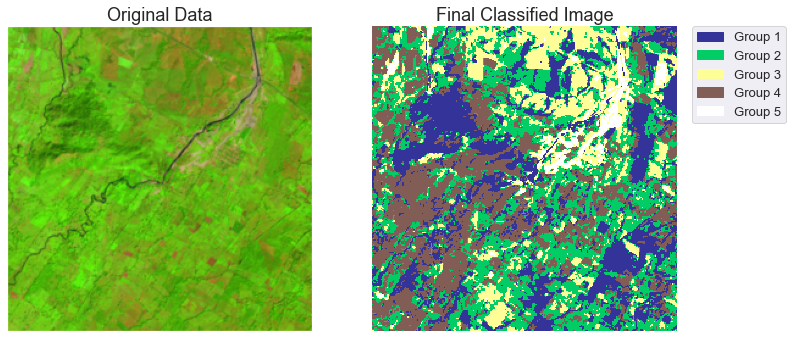

In [102]:
# Plotting the classified data next to the original data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ep.plot_rgb(landsat_xr.values,
            rgb=[4, 3, 2],
            ax=ax1)
ax1.set_title("Original Data")

im2 = ax2.imshow(prediction,
                 cmap="terrain",
                 interpolation='none')
ax2.axis('off')
ep.draw_legend(im_ax=im2,
               titles=groups)
ax2.set_title("Final Classified Image")

plt.show()

## You will get different results for different values of k
Depending on your data, some values of k will produce "better" results (we'll talk about some ways to measure this)

In [10]:
# Looping through multiple numbers of iterations
# Do we ever get a water class?
nclusters = range(3, 30)
kmeans_dict = {}
predictions = {}
for k in nclusters:
    kmeans_dict[k] = KMeans(n_clusters=k).fit(landsat_sk_xr)
    predictions[k] = (
        kmeans_dict[k]
        .predict(landsat_sk_xr)
        .reshape(landsat_xr[0, :, :].shape))

['{}, {}'.format(k, classes.max()) for k, classes in predictions.items()]

['3, 2',
 '4, 3',
 '5, 4',
 '6, 5',
 '7, 6',
 '8, 7',
 '9, 8',
 '10, 9',
 '11, 10',
 '12, 11',
 '13, 12',
 '14, 13',
 '15, 14',
 '16, 15',
 '17, 16',
 '18, 17',
 '19, 18',
 '20, 19',
 '21, 20',
 '22, 21',
 '23, 22',
 '24, 23',
 '25, 24',
 '26, 25',
 '27, 26',
 '28, 27',
 '29, 28']

### Let's take a look at some of the clusters

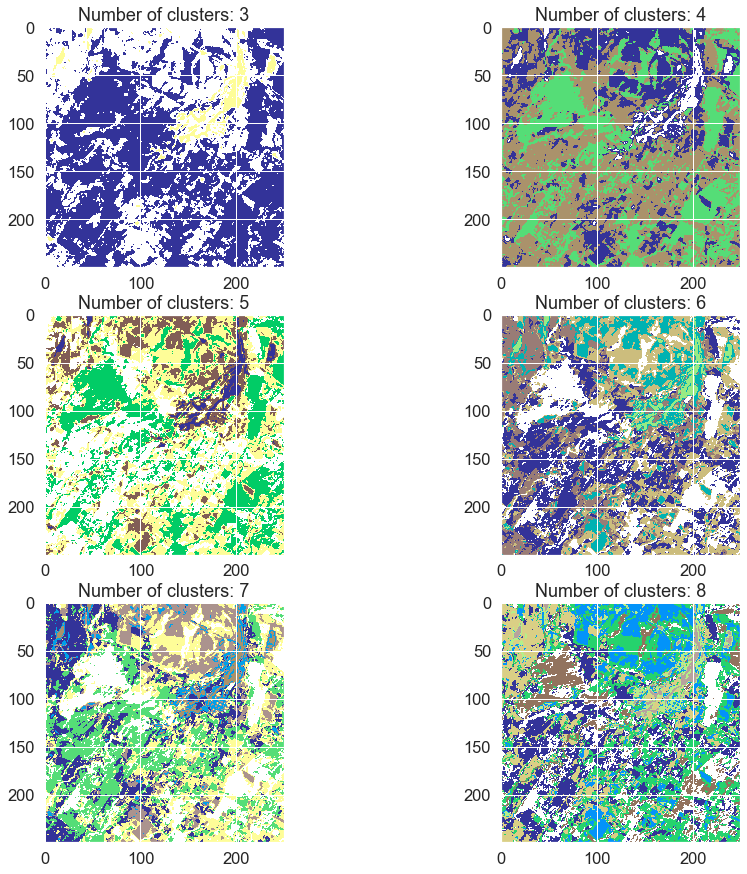

In [103]:

f, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if ax_i > 5:
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction,
                   cmap="terrain",
                   interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
plt.show()

## How far away are the clusters from each other?

For a given datapoint intra-cluster distance should always be less than inter-cluster distance.

Inertia is the measure of intra-cluster distances, relative to inter-cluster variation. Data points in the same cluster should be well matched and similar to each other. Lower inertia means data points in clusters are more similar.

Text(0.5, 1.0, 'Inertia for different numbers of clusters')

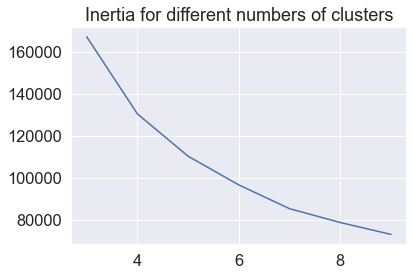

In [104]:
inertia = {k: fit.inertia_ for k, fit in kmeans_dict.items()}
plt.plot(inertia.keys(), inertia.values())
plt.title('Inertia for different numbers of clusters')

## The Earth has distinctive spectral signatures
In other words, our reflectance data aren't distributed evenly and independently. Let's take a look. Do you notice any bands that appear correlated to each other?

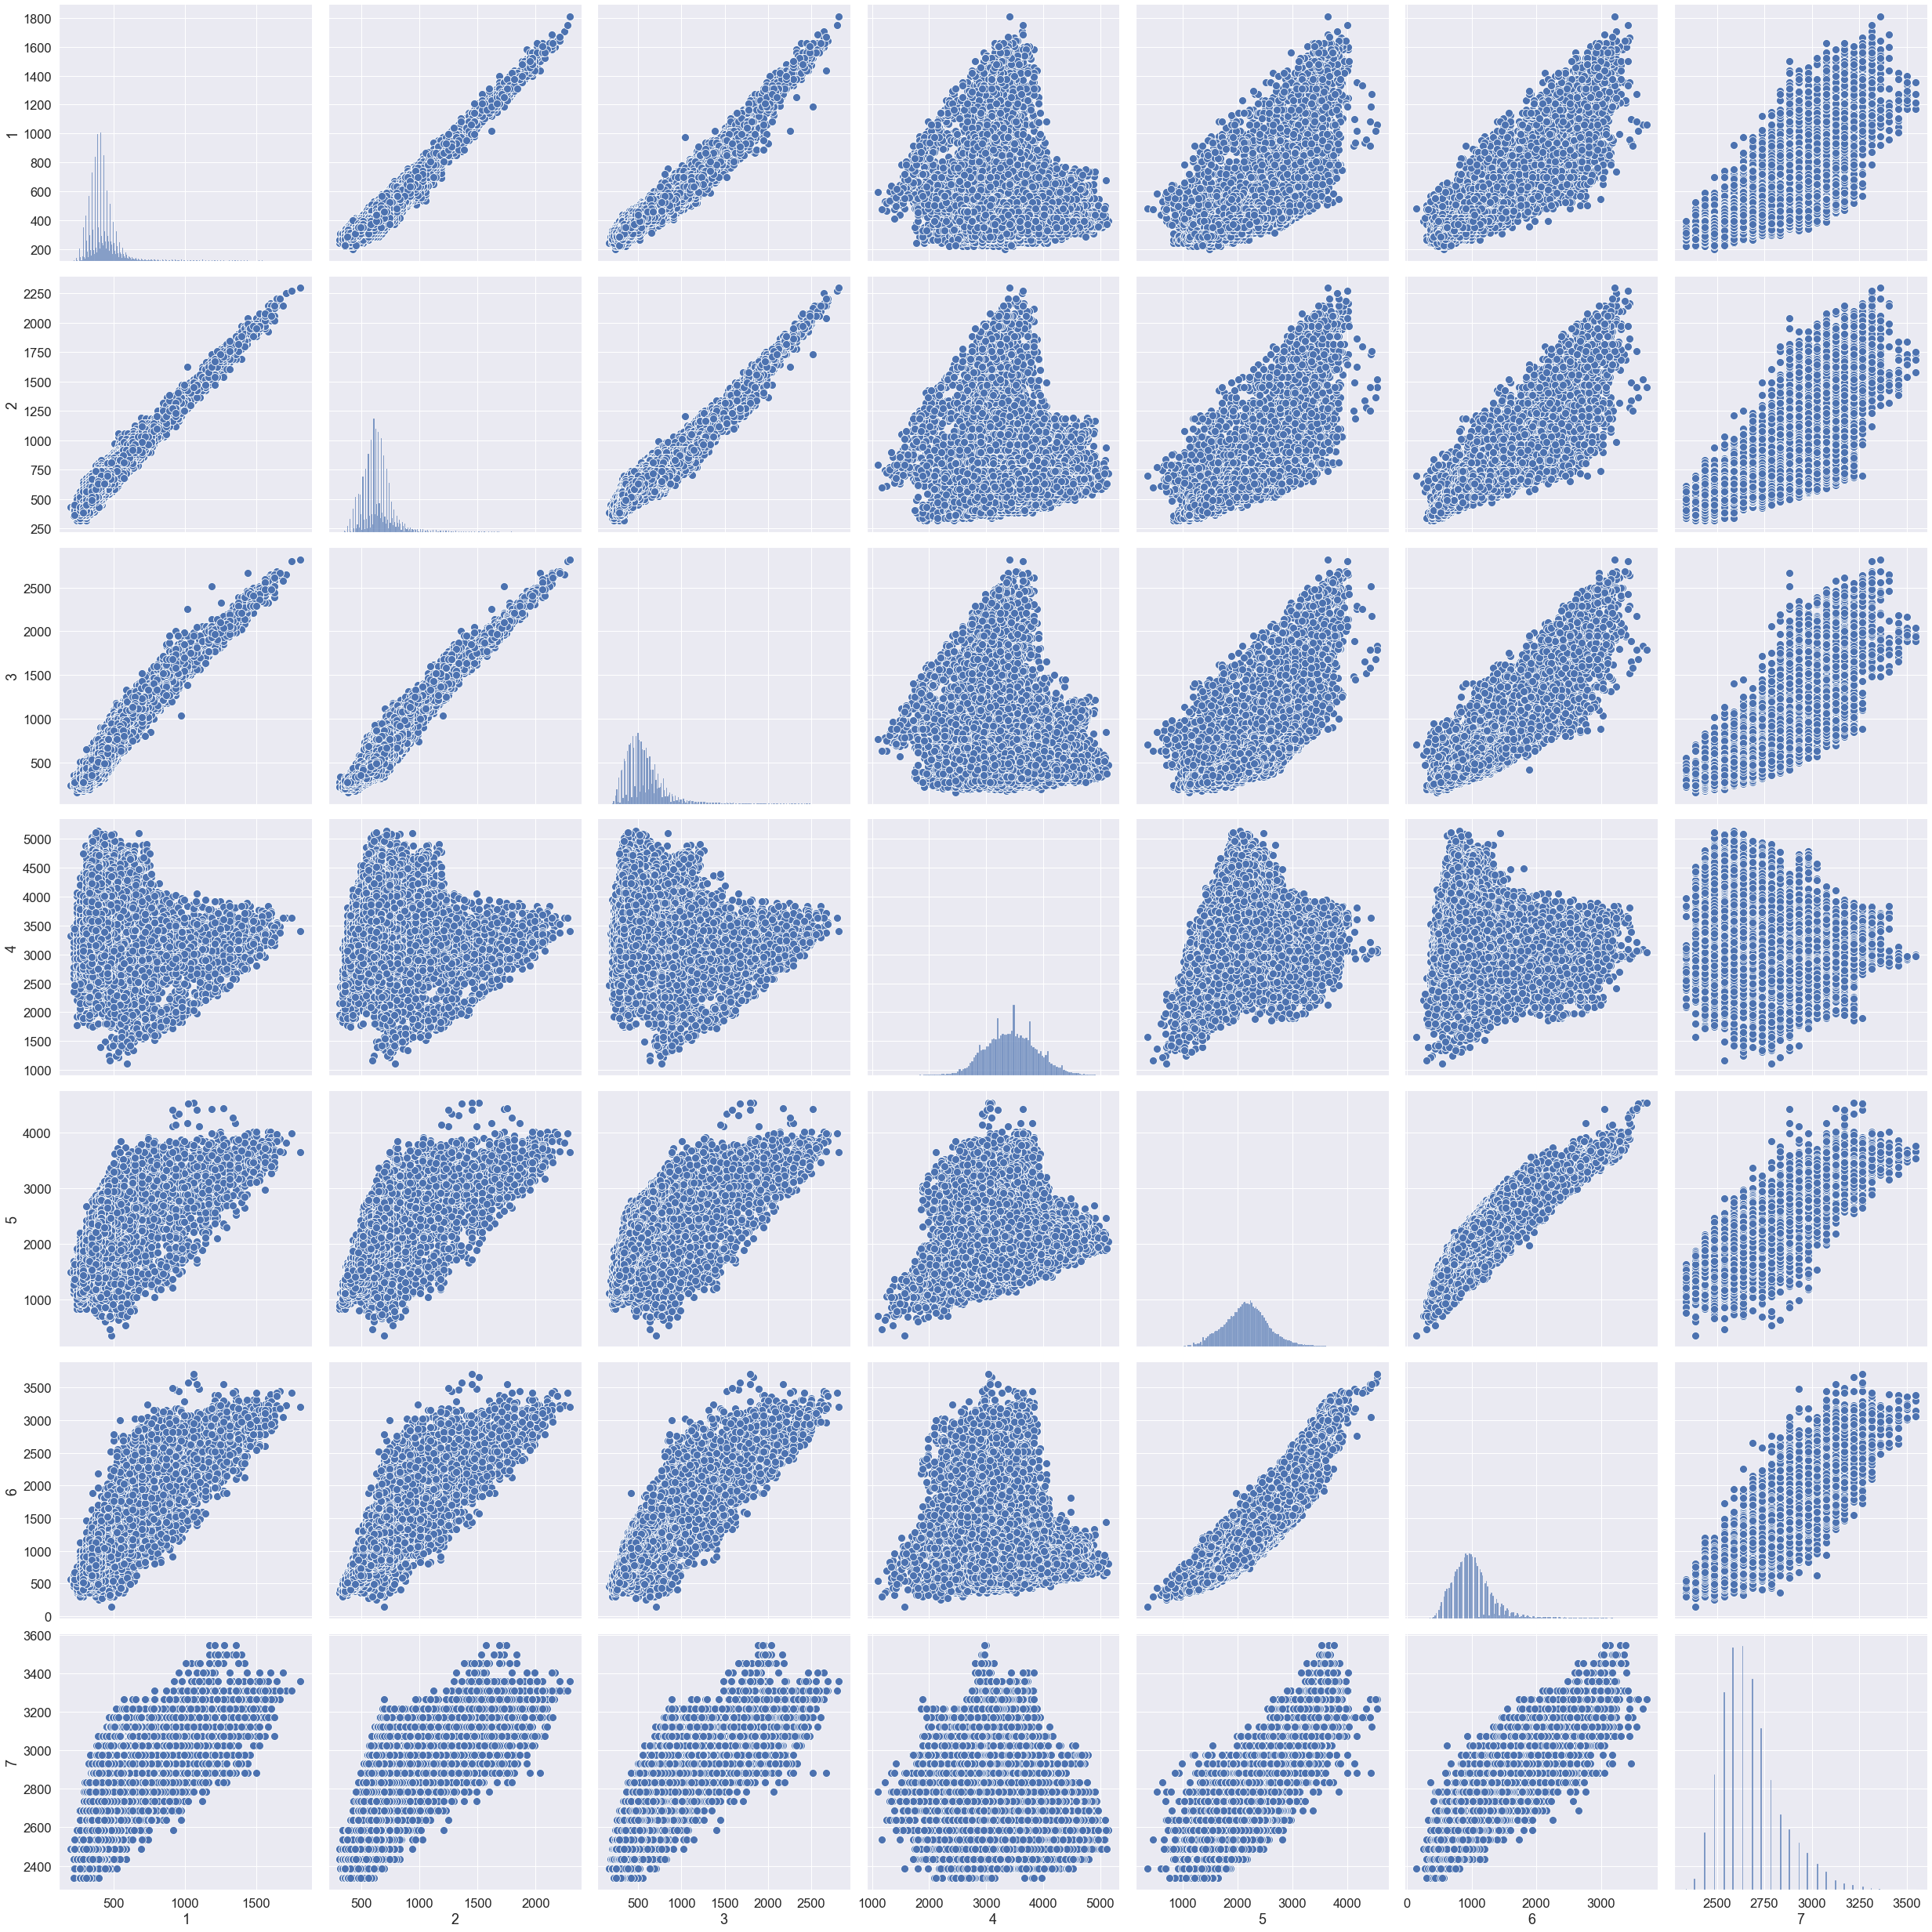

In [105]:
sns.set(font_scale=1.5)
band_list = [1, 2, 3]
sns.pairplot(landsat_df,
             height=5,
             plot_kws={"s": 100})
plt.show()

Looks like bands 1, 2, and 3 are highly correlated, and so are bands 5 and 6.

We also have another problem, which is that the axes of our pair plot facets are different by as much as 2x. That means that variation in band 4 **counts for more** than variation in band 1, since k-means uses the **Euclidean distance**.

Normally we would correct both of these problems by normalizing our data and then performing **Principle Component Analysis** on it.

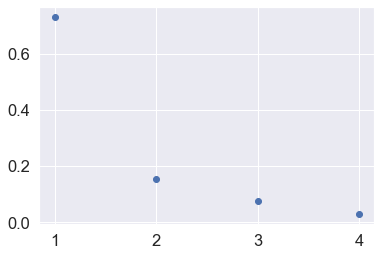

In [106]:
n_components = 4
landsat_norm = StandardScaler().fit_transform(landsat_sk_df.values)
landsat_pc = PCA(n_components=n_components).fit(landsat_norm)
plt.scatter(
    y=landsat_pc.explained_variance_ratio_, 
    x=[n+1 for n in range(n_components)])

In [107]:
landsat_red = landsat_pc.transform(landsat_norm)

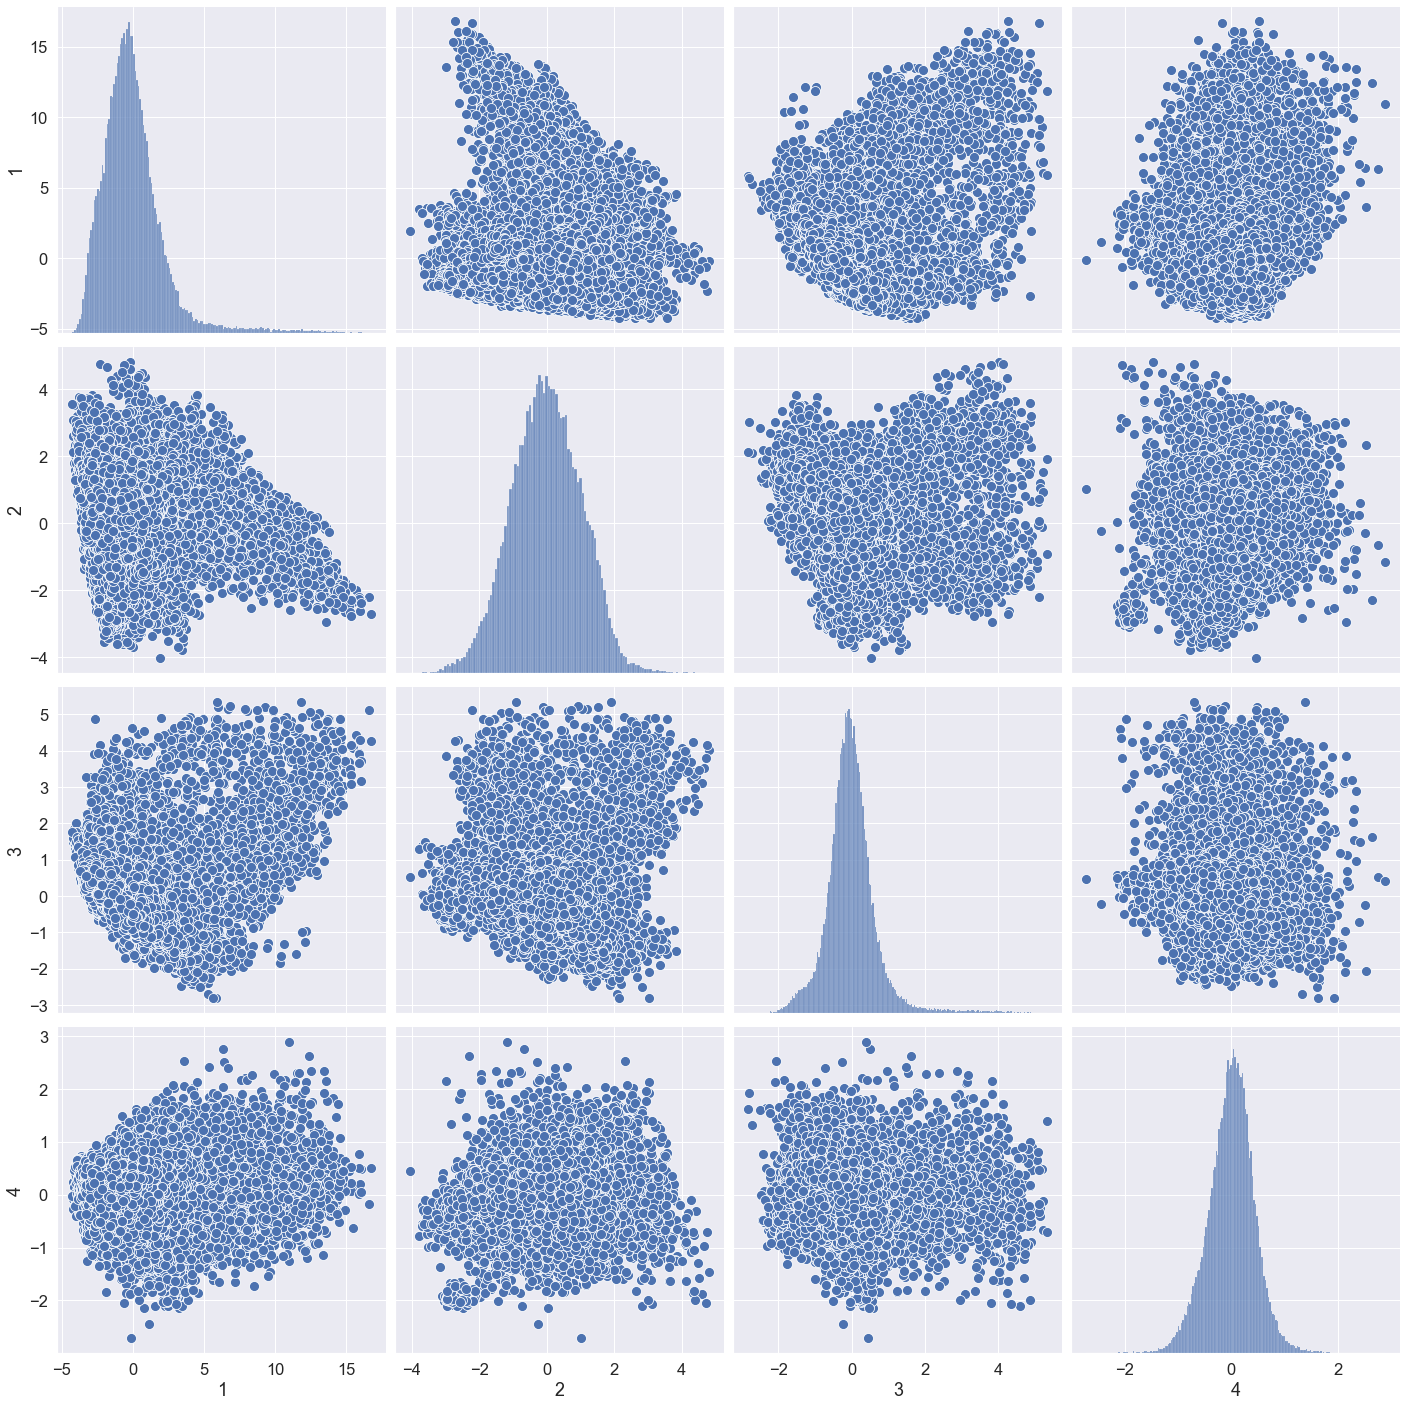

In [108]:
sns.set(font_scale=1.5)
band_list = [1, 2, 3]
sns.pairplot(pd.DataFrame(landsat_red, columns=(1, 2, 3, 4)),
             height=5,
             plot_kws={"s": 100})
plt.show()

In [109]:
nclusters = range(3, 10)
kmeans_dict = {}
predictions = {}
for k in nclusters:
    print('Fitting to {} clusters'.format(k))
    kmeans_dict[k] = KMeans(n_clusters=k).fit(landsat_red)
    predictions[k] = (
        kmeans_dict[k]
        .predict(landsat_red)
        .reshape(landsat_xr[0, :, :].shape))

Fitting to 3 clusters
Fitting to 4 clusters
Fitting to 5 clusters
Fitting to 6 clusters
Fitting to 7 clusters
Fitting to 8 clusters
Fitting to 9 clusters


Text(0.5, 1.0, 'Inertia for different numbers of clusters')

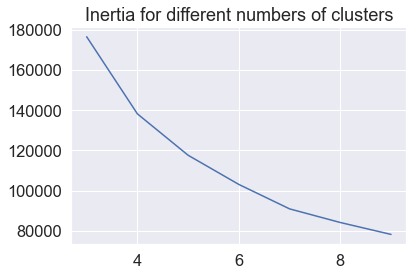

In [110]:
inertia = {k: fit.inertia_ for k, fit in kmeans_dict.items()}
plt.plot(inertia.keys(), inertia.values())
plt.title('Inertia for different numbers of clusters')

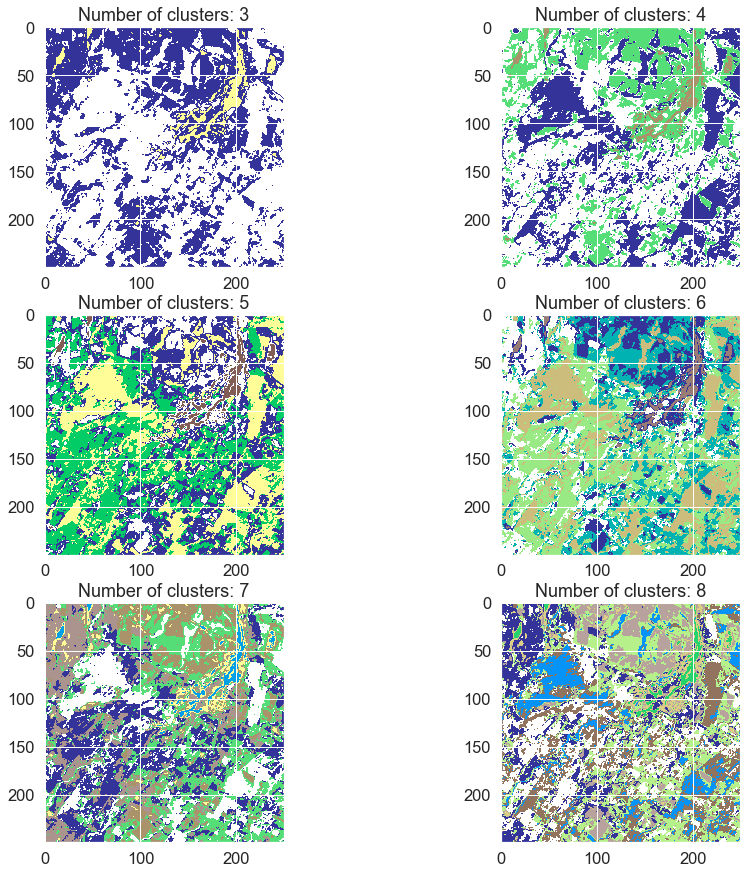

In [111]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))

for ax_i, (k, prediction) in enumerate(predictions.items()):
    if (ax_i >= 6):
        continue
    ax = axes.flatten()[ax_i]
    im = ax.imshow(prediction,
                   cmap="terrain",
                   interpolation='none')
    ax.set_title("Number of clusters: " + str(k))
plt.show()

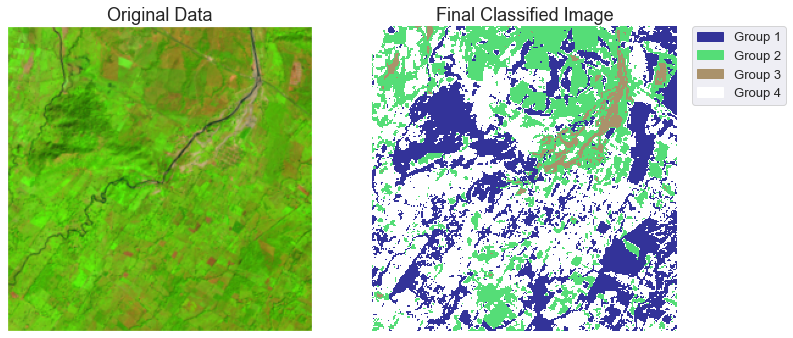

In [114]:
# Plotting the classified data next to the original data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ep.plot_rgb(landsat_xr.values,
            rgb=[4, 3, 2],
            ax=ax1)
ax1.set_title("Original Data")

im2 = ax2.imshow(predictions[4],
                 cmap="terrain",
                 interpolation='none')
ax2.axis('off')
ep.draw_legend(im_ax=im2,
               titles=groups[:-1])
ax2.set_title("Final Classified Image")

plt.show()